# Customer Complaints Sentiment and Priority Dataset

### 1. Import Libraries

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK datasets
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\milto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 2. Load the Data

In [2]:
file_path = 'Customer Complaints Sentiment and Priority Dataset.csv'
df = pd.read_csv(file_path)

# Display dataset info
print(df.head())
print(df.info())

# Check class distributions
print(df['Product'].value_counts())
print(df['Sentiment'].value_counts())
print(df['Priority'].value_counts())

                                  Consumer_complaint  \
0  I had overdraft protection with Regions Bank i...   
1  I am the sole, legal representative of my dece...   
2  This bank has consistantly manipulated my dire...   
3  I enrolled in a Citibank checking account in X...   
4  TIAA-XXXX  has not responded to multiple reque...   

                                  Product  Sentiment  Priority  
0  Checking or savings account or service          0         1  
1  Checking or savings account or service          0         1  
2  Checking or savings account or service          0         0  
3  Checking or savings account or service          0         1  
4  Checking or savings account or service          0         1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Consumer_complaint  1750 non-null   object
 1   Product           

### 3. Data Preprocessing

In [3]:
def clean_text(text):
    """Cleans text by removing special characters, numbers, and extra spaces."""
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', ' ', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

df['Cleaned_Complaint'] = df['Consumer_complaint'].apply(clean_text)

# Display cleaned complaints
print(df[['Consumer_complaint', 'Cleaned_Complaint']].head())

                                  Consumer_complaint  \
0  I had overdraft protection with Regions Bank i...   
1  I am the sole, legal representative of my dece...   
2  This bank has consistantly manipulated my dire...   
3  I enrolled in a Citibank checking account in X...   
4  TIAA-XXXX  has not responded to multiple reque...   

                                   Cleaned_Complaint  
0  i had overdraft protection with regions bank i...  
1  i am the sole legal representative of my decea...  
2  this bank has consistantly manipulated my dire...  
3  i enrolled in a citibank checking account in x...  
4  tiaa xxxx has not responded to multiple reques...  


In [4]:
# Handle sentiment class imbalance
print("Sentiment distribution before resampling:\n", df['Sentiment'].value_counts())
df_majority = df[df['Sentiment'] == 0]
df_minority = df[df['Sentiment'] == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])
print("Sentiment distribution after resampling:\n", df_balanced['Sentiment'].value_counts())

# Remove stopwords & Tokenize text
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """Removes stopwords from text."""
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df_balanced['Cleaned_Complaint'] = df_balanced['Cleaned_Complaint'].apply(remove_stopwords)

# Display cleaned complaints after stopword removal
print(df_balanced[['Cleaned_Complaint']].head())


Sentiment distribution before resampling:
 Sentiment
0    1295
1     455
Name: count, dtype: int64
Sentiment distribution after resampling:
 Sentiment
0    1295
1    1295
Name: count, dtype: int64
                                   Cleaned_Complaint
0  overdraft protection regions bank xxxx alabama...
1  sole legal representative deceased mother esta...
2  bank consistantly manipulated direct deposits ...
3  enrolled citibank checking account xxxx using ...
4  tiaa xxxx responded multiple requests trustee ...


In [5]:
# --- Feature Extraction using TF-IDF ---
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_balanced['Cleaned_Complaint']).toarray()

# Define labels
y_sentiment = df_balanced['Sentiment']
y_priority = df_balanced['Priority']

In [6]:
# --- Address Class Imbalance for Priority Classification ---
smote = SMOTE(random_state=42)
X_resampled, y_priority_resampled = smote.fit_resample(X, y_priority)

# Train-test split after resampling
X_train_priority, X_test_priority, y_train_priority, y_test_priority = train_test_split(
    X_resampled, y_priority_resampled, test_size=0.2, random_state=42
)

### 4. Experimenting with Different Models

In [7]:
# GridSearchCV for Hyperparameter Optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train_priority, y_train_priority)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the optimized model
y_pred_priority = best_model.predict(X_test_priority)
print("Optimized Priority Classification Results:")
print(classification_report(y_test_priority, y_pred_priority))
print("Accuracy:", accuracy_score(y_test_priority, y_pred_priority))

Optimized Priority Classification Results:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       401
           1       0.93      0.99      0.96       452

    accuracy                           0.95       853
   macro avg       0.96      0.95      0.95       853
weighted avg       0.95      0.95      0.95       853

Accuracy: 0.9519343493552169


### 5. Feature Importance Analysis

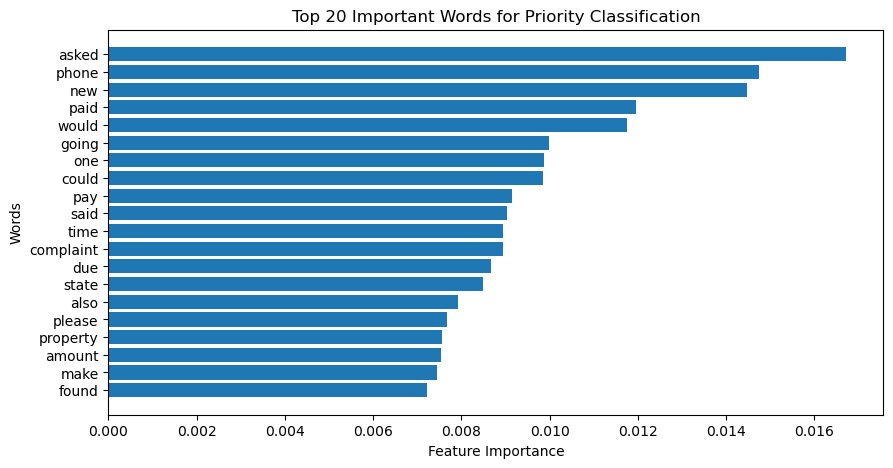

In [8]:
feature_importances = best_model.feature_importances_
feature_names = tfidf.get_feature_names_out()

# Sort and visualize top 20 important words
sorted_idx = np.argsort(feature_importances)[-20:]
plt.figure(figsize=(10, 5))
plt.barh(np.array(feature_names)[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Words")
plt.title("Top 20 Important Words for Priority Classification")
plt.show()

### 6. Visualization

C:\Users\milto\AppData\Local\Temp\ipykernel_6584\1221055866.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='Set2')


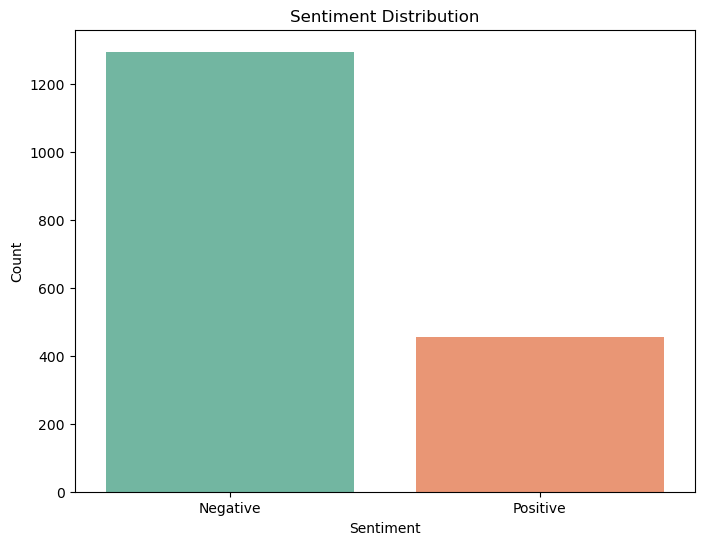

C:\Users\milto\AppData\Local\Temp\ipykernel_6584\1221055866.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Priority', data=df, palette='Set3')


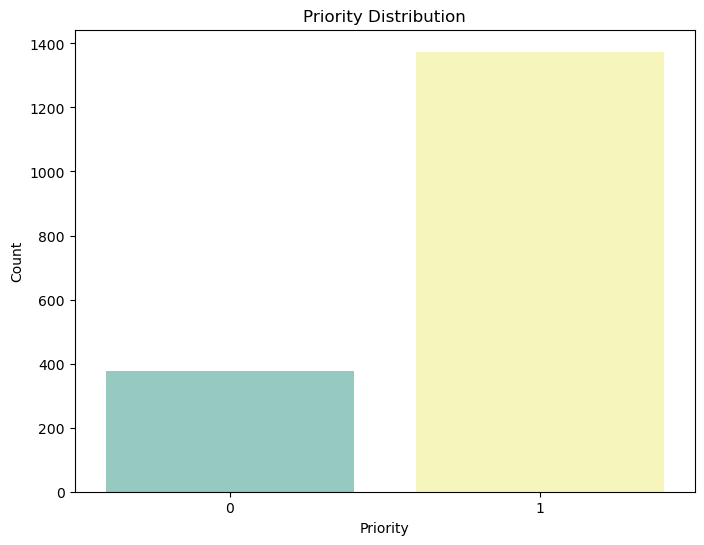

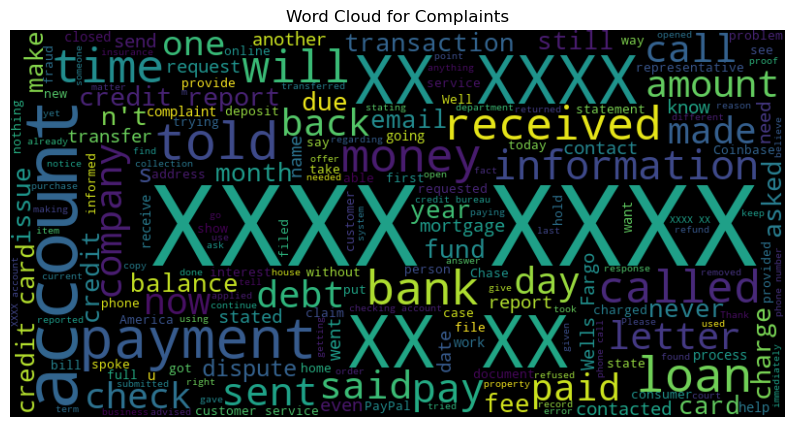

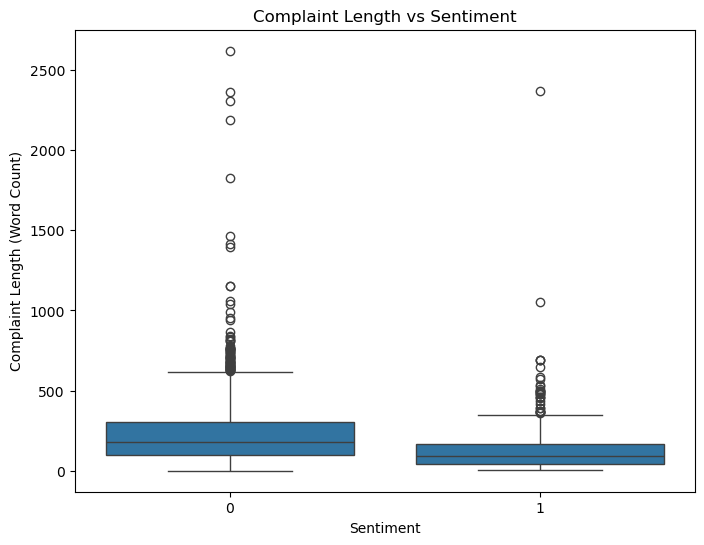

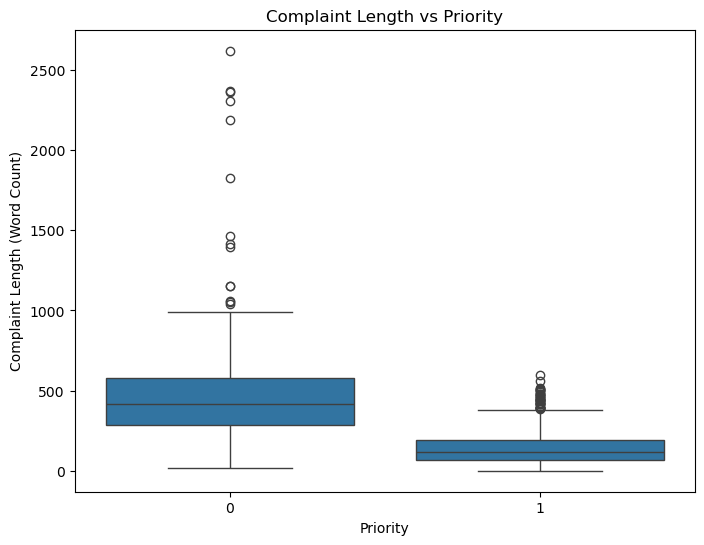

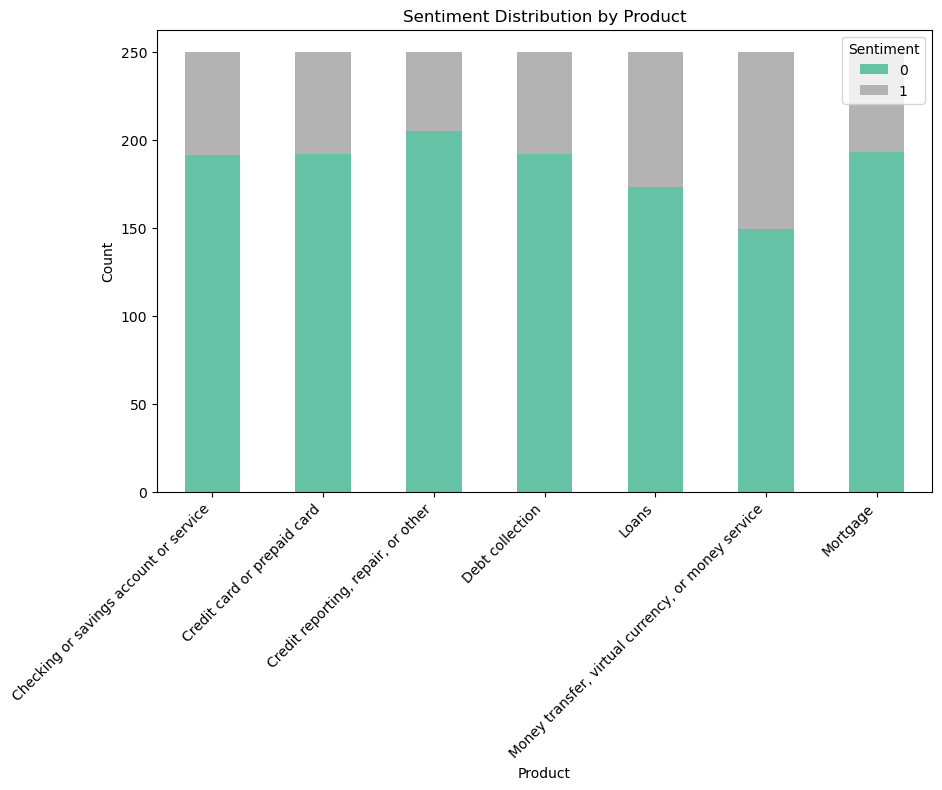

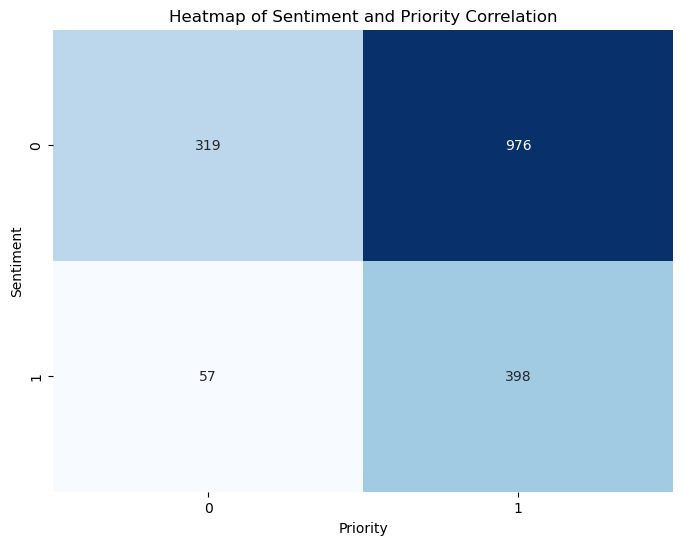

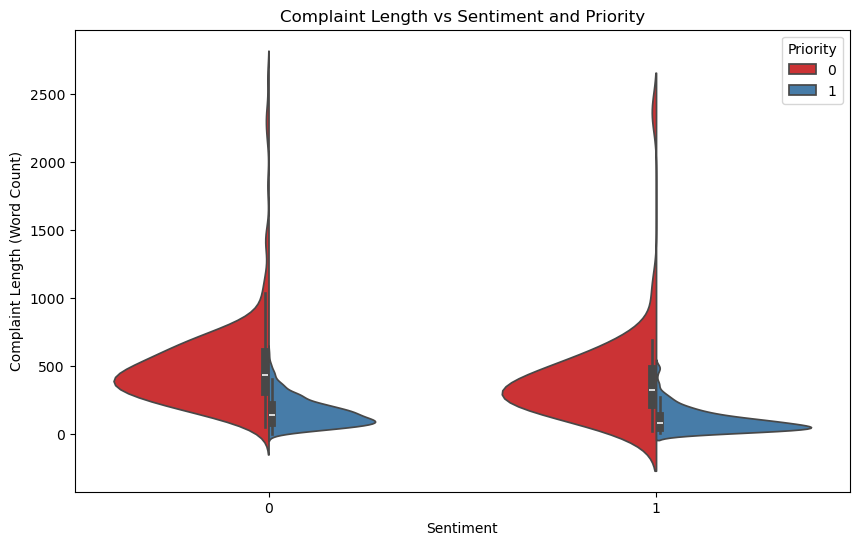

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Assuming df is your DataFrame containing the data
# Example: df = pd.read_csv("your_data.csv")

# 1. Sentiment Distribution (Bar chart)
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# 2. Priority Distribution (Bar chart)
plt.figure(figsize=(8, 6))
sns.countplot(x='Priority', data=df, palette='Set3')
plt.title('Priority Distribution')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.show()

# 3. Word Cloud for Top Complaints (Word Cloud)
text = ' '.join(df['Consumer_complaint'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Complaints')

# 5. Complaint Length vs Sentiment (Box plot)
df['Complaint_Length'] = df['Consumer_complaint'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='Complaint_Length', data=df)
plt.title('Complaint Length vs Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Complaint Length (Word Count)')
plt.show()

# 6. Complaint Length vs Priority (Box plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Priority', y='Complaint_Length', data=df)
plt.title('Complaint Length vs Priority')
plt.xlabel('Priority')
plt.ylabel('Complaint Length (Word Count)')
plt.show()

# 7. Sentiment vs Product Type (Stacked Bar Chart)
plt.figure(figsize=(10, 6))
sentiment_product = pd.crosstab(df['Product'], df['Sentiment'])
sentiment_product.plot(kind='bar', stacked=True, cmap='Set2', ax=plt.gca())
plt.title('Sentiment Distribution by Product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# 8. Heatmap of Sentiment and Priority Correlation (Heatmap)
sentiment_priority = pd.crosstab(df['Sentiment'], df['Priority'])
plt.figure(figsize=(8, 6))
sns.heatmap(sentiment_priority, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Heatmap of Sentiment and Priority Correlation')
plt.xlabel('Priority')
plt.ylabel('Sentiment')
plt.show()

# 9. Complaint Text Analysis - Sentiment and Priority Comparison (Violin plot)
plt.figure(figsize=(10, 6))
sns.violinplot(x="Sentiment", y="Complaint_Length", hue="Priority", data=df, split=True, palette='Set1')
plt.title('Complaint Length vs Sentiment and Priority')
plt.xlabel('Sentiment')
plt.ylabel('Complaint Length (Word Count)')
plt.show()
